In [1]:
from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

from utils.plotting import plot_VAE_performance, plot_image_channels, extract_a_few_images
from utils.data_preparation import create_directory, read_metadata, get_relative_image_paths, load_images
from utils.utils import cprint
from utils.profiling import LatentVariableExtraction
from utils.plotting import heatmap, plot_cosine_similarity
from utils.plotting import NSC_NearestNeighbor_Classifier, moa_confusion_matrix, Accuracy
from utils.profiling import treatment_profiles, treatment_center_cells
        
from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

from models.LoadModels import LoadVAEmodel, initVAEmodel
from utils.data_transformers import normalize_every_image_channels_seperately_inplace
from utils.data_transformers import normalize_channels_inplace, batch_normalize_images
from utils.data_transformers import SingleCellDataset
from utils.plotting import plot_VAE_performance, plot_image_channels, extract_a_few_images
from utils.data_preparation import create_directory, read_metadata, get_relative_image_paths, load_images
from utils.data_preparation import read_metadata_and_images
from utils.data_preparation import get_MOA_mappings, shuffle_metadata, split_metadata
from utils.utils import cprint, get_datetime, create_logfile, constant_seed, StatusString
from utils.utils import save_model
from utils.profiling import LatentVariableExtraction
from utils.plotting import heatmap, plot_cosine_similarity
from utils.plotting import NSC_NearestNeighbor_Classifier, moa_confusion_matrix, Accuracy
from downstream_task import downstream_task
from utils.plotting import *
import importlib

import sklearn.metrics
from VAE_trainer import VAE_trainer 
from VAEGAN_trainer import VAEGAN_trainer



In [2]:
######### Utilities #########
# choose correct output folder for LoadVAEmodel() below!!!
output_folder = "./dump/outputs_2023-01-01 - 11-05-09/"

constant_seed()
logfile = create_logfile(output_folder + "downstream_log.log")
cprint("output_folder is: {}".format(output_folder), logfile)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cprint(f"Using device: {device}", logfile)

images, metadata, mapping = read_metadata_and_images(use_server_path = False, \
                                                        load_images_from_individual_files = True, 
                                                        load_subset_of_images = 1000, 
                                                        save_images_to_singlefile = False,
                                                        logfile = logfile)
# Settings for handing in:
#images, metadata, mapping = read_metadata_and_images(use_server_path = True, \
#                                                        load_images_from_individual_files = True, 
#                                                        load_subset_of_images = None, 
#                                                        save_images_to_singlefile = False)

# With the below command, we normalize all the images, image- and channel-wise.
# Alternative, this can be uncommented and like in the Lafarge article, we can do batchwise normalization
normalize_every_image_channels_seperately_inplace(images, verbose=True)

metadata = shuffle_metadata(metadata)
metadata_train, metadata_validation = split_metadata(metadata, split_fraction = .90)

train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)

#### LOAD TRAINED MODEL ####
model, validation_data, training_data, params, vi = LoadVAEmodel(output_folder)

cprint("model is of type {}".format(params['model_type']), logfile)
cprint("model parameters are: {}".format(params), logfile)

vae = model[0]

if params['model_type'] in ['SparseVAEGAN', 'CytoVAEGAN']:
    gan = model[1]

train_loader = DataLoader(train_set, batch_size=params['batch_size'], shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=max(2, params['batch_size']), shuffle=False, num_workers=0, drop_last=False)

_ = vae.eval() # because of batch normalization

    
cprint("output_folder is: {}".format(output_folder), logfile)
cprint("script done.", logfile)

12:52:57 | output_folder is: ./dump/outputs_2023-01-01 - 11-05-09/
12:52:57 | Using device: cpu
12:52:58 | Using a subset of the metadata
12:52:58 | loaded metadata
12:52:58 | loading images
12:52:58 | loading images from individual files
12:52:58 | loading images now
verbose:  True
12:52:58 | loaded 0/1000 images (0.00%).
12:52:58 | loaded 10/1000 images (1.00%).
12:52:58 | loaded 20/1000 images (2.00%).
12:52:58 | loaded 30/1000 images (3.00%).
12:52:58 | loaded 40/1000 images (4.00%).
12:52:58 | loaded 50/1000 images (5.00%).
12:52:58 | loaded 60/1000 images (6.00%).
12:52:58 | loaded 70/1000 images (7.00%).
12:52:58 | loaded 80/1000 images (8.00%).
12:52:58 | loaded 90/1000 images (9.00%).
12:52:58 | loaded 100/1000 images (10.00%).
12:52:58 | loaded 110/1000 images (11.00%).
12:52:58 | loaded 120/1000 images (12.00%).
12:52:58 | loaded 130/1000 images (13.00%).
12:52:58 | loaded 140/1000 images (14.00%).
12:52:58 | loaded 150/1000 images (15.00%).
12:52:58 | loaded 160/1000 images

In [3]:
def plot_cosine_similarity(x0, x1, model, file=None, title=None, control_text="Control",  target_text="Target"):
    #model could be eg. "model_dump/outputs_2022-12-04 - 12-20-15/"
    #x0.shape and x1.shape should be torch.Size([3, 68, 68])
    
    #vae, validation_data, training_data, VAE_settings = LoadVAEmodel(model)
    vae = model
    outputs0 = vae(x0[None,:,:,:])
    outputs1 = vae(x1[None,:,:,:])

    z0 = outputs0["z"]
    z1 = outputs1["z"]

    zs = [z0] + list(np.linspace(z0.detach().numpy(), z1.detach().numpy(), num=8)) + [z1]

    cos_sim = np.CosineSimilarity(dim=1, eps=1e-6)

    cp = []
    for i in range(len(zs)):
        mycosine = sklearn.metrics.pairwise.cosine_similarity(zs[i], z1)[0][0]
        #print("mycosine", mycosine)
        cp.append(mycosine)
        
        #cp.append(cos(zs[i], zs[9]).mean().detach().numpy().round(2))

    # create figure
    fig = plt.figure(figsize=(25, 10))

    # setting values to rows and column variables
    rows = 1
    columns = len(zs)

    # Adds a subplot at the 1st position
    for i in range(columns):
        if i == 0:
            fig.add_subplot(rows, columns, i+1)
            img = view_as_image_plot_format(x0)
            plt.imshow(img)
            plt.axis('off')
        elif i == columns-1:
            fig.add_subplot(rows, columns, i+1)
            img = view_as_image_plot_format(x1)
            plt.imshow(img)
            plt.axis('off')
        else:
            fig.add_subplot(rows, columns, i+1)
            plt.imshow((torch.permute(vae.observation(torch.Tensor(zs[i]))[0], (1, 2, 0)) * 255).detach().numpy().astype(np.uint8))
            plt.axis('off')
        if i == 0:
            plt.title('Control', y=-0.20, fontsize=26)
        elif i == len(zs)-1:
            plt.title(target_text, y=-0.20, fontsize=26)
        else:
            plt.title("{:.2f}".format(cp[i]), fontsize=26)
    if file == None:
        plt.show()
    else: 
        plt.savefig(file)
        plt.show()
    
    plt.close()

In [34]:
import sklearn
from numpy import dot
from numpy.linalg import norm

def plot_cosine_similarity(x0, x1, model, file=None, title=None, control_text="Control",  target_text="Target"):
    #model could be eg. "model_dump/outputs_2022-12-04 - 12-20-15/"
    #x0.shape and x1.shape should be torch.Size([3, 68, 68])
    
    #vae, validation_data, training_data, VAE_settings = LoadVAEmodel(model)
    vae = model
    outputs0 = vae(x0[None,:,:,:])
    outputs1 = vae(x1[None,:,:,:])

    z0 = outputs0["z"].detach().numpy()
    z1 = outputs1["z"].detach().numpy()

    zs = [z0] + list(np.linspace(z0, z1, num=8)) + [z1]

    cp = []
    for i in range(len(zs)):
        cos_sim = (dot(zs[i], z1.transpose())/(norm(zs[i])*norm(z1.transpose())))[0][0]
        cp.append(cos_sim)
        
        #cp.append(cos(zs[i], zs[9]).mean().detach().numpy().round(2))

    # create figure
    fig = plt.figure(figsize=(25, 10))

    # setting values to rows and column variables
    rows = 1
    columns = len(zs)

    # Adds a subplot at the 1st position
    for i in range(columns):
        if i == 0:
            fig.add_subplot(rows, columns, i+1)
            img = view_as_image_plot_format(x0)
            plt.imshow(img)
            plt.axis('off')
        elif i == columns-1:
            fig.add_subplot(rows, columns, i+1)
            img = view_as_image_plot_format(x1)
            plt.imshow(img)
            plt.axis('off')
        else:
            fig.add_subplot(rows, columns, i+1)
            plt.imshow((torch.permute(vae.observation(torch.Tensor(zs[i]))[0], (1, 2, 0)) * 255).detach().numpy().astype(np.uint8))
            plt.axis('off')
        if i == 0:
            plt.title('Control', y=-0.20, fontsize=26)
        elif i == len(zs)-1:
            plt.title(target_text, y=-0.20, fontsize=26)
        else:
            plt.title("{:.2f}".format(cp[i]), fontsize=26)
    if file == None:
        plt.show()
    else: 
        plt.savefig(file)
        plt.show()
    
    plt.close()

15:15:05 | Starting downstream tasks
15:15:05 | Calculate latent representation for all images
Profiling 0/1 batches of size 1000
15:15:07 | Done calculating latent sapce
15:15:07 | Plotting interpolations of reconstructions
doing:  ./dump/outputs_2023-01-01 - 11-05-09/interpolations/ALLN_3.0.png
type(zs[i]): <class 'numpy.ndarray'>
type(z1): <class 'numpy.ndarray'>
zs[i].shape): (1, 256)
z1.shape: (1, 256)
cos_sim -0.0096566435
type(zs[i]): <class 'numpy.ndarray'>
type(z1): <class 'numpy.ndarray'>
zs[i].shape): (1, 256)
z1.shape: (1, 256)
cos_sim -0.0096566435
type(zs[i]): <class 'numpy.ndarray'>
type(z1): <class 'numpy.ndarray'>
zs[i].shape): (1, 256)
z1.shape: (1, 256)
cos_sim 0.17175645
type(zs[i]): <class 'numpy.ndarray'>
type(z1): <class 'numpy.ndarray'>
zs[i].shape): (1, 256)
z1.shape: (1, 256)
cos_sim 0.3965407
type(zs[i]): <class 'numpy.ndarray'>
type(z1): <class 'numpy.ndarray'>
zs[i].shape): (1, 256)
z1.shape: (1, 256)
cos_sim 0.63332164
type(zs[i]): <class 'numpy.ndarray'>


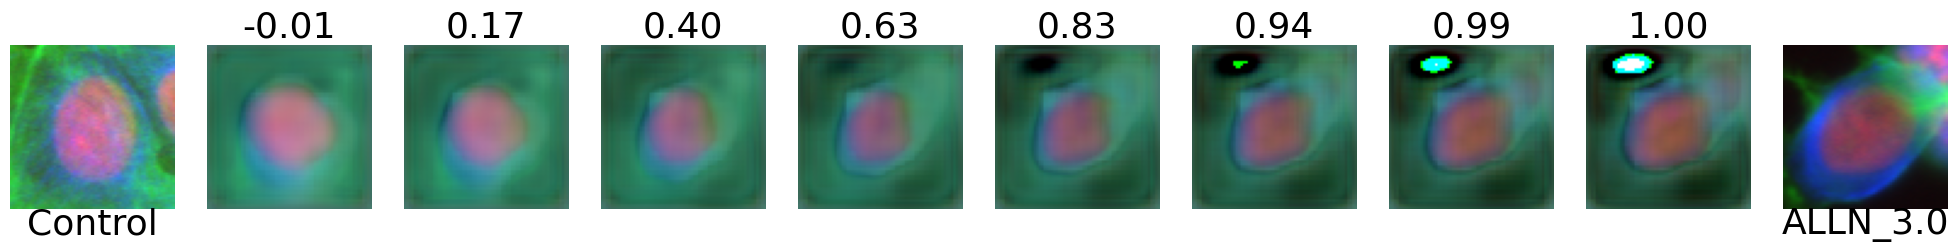

In [35]:
cprint("Starting downstream tasks", logfile)

_ = vae.eval() # because of batch normalization

#### CALCULATE LATENT REPRESENTATION FOR ALL IMAGES ####
cprint("Calculate latent representation for all images", logfile)
batch_size= 10000
metadata_latent = LatentVariableExtraction(metadata, images, batch_size, vae)
cprint("Done calculating latent sapce", logfile)

#### PLOT INTERPOLATION OF RECONSTRUCTONS ####
def plot_control_cell_to_target_cell(target, images, df, model,file = None, control='DMSO_0.0', control_text = 'DMSO',  target_text=None):
    tp = treatment_profiles(df)
    tcc = treatment_center_cells(df,tp,p=2)
    control_cell = images[tcc[tcc['Treatment'] == 'DMSO_0.0'].index[0]]
    target_cell = images[tcc[tcc['Treatment'] == target].index[0]]
    plot_cosine_similarity(control_cell, target_cell, model, file=file, title=None, control_text = control_text,  target_text=treatment) 
    return 

cprint("Plotting interpolations of reconstructions", logfile)
create_directory(output_folder + "interpolations")
#treatments list
tl = metadata['Treatment'].sort_values().unique()
for treatment in [tl[0]]:
#    for treatment in tl:
    filename = output_folder + "interpolations/" + treatment.replace('/', "_") + ".png"
    print("doing: ", filename)
    plot_control_cell_to_target_cell(treatment, images, metadata_latent, vae, file=filename,  control='DMSO_0.0', control_text = 'DMSO',  target_text=treatment)

